In [15]:
# Train a regression to predict the mCG level of all DMRs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import datetime, random, glob, time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# Set random seeds
torch.manual_seed(0)
np.random.seed(0)


cuda:0


In [16]:
use_kmers = True
N1 = 64
N2 = 32
lr = 0.002
batch_size = 64 if use_kmers else 32

In [17]:
today=datetime.datetime.today().strftime('%d-%m-%Y')
fn_load_prefix = 'RegressData/Regress_data_9868genes_21cells_'
fn_id = len(glob.glob('./RegressEnh*.pt'))+1 # Generate a unique ID for this run
fn_save = 'RegressEnh%0.4d_%s_N_%d_%d.%s.pt' % (fn_id, ('UseKmers' if use_kmers else 'NoKmers'), N1,N2,today)
fn_save, fn_id

('RegressEnh0024_UseKmers_N_64_32.28-02-2020.pt', 24)

In [18]:
# Load datasets
# save_vars = ['genes2enhu', 'rnau', 'df_mlevelu', 'df_atacu', 'genes']
save_vars = ['rnau','genes']
for var in save_vars:
    fn = fn_load_prefix+var+'.pkl'
    cmd = '%s=pd.read_pickle("%s")' % (var, fn)
    exec(cmd)
    print('Loaded %s' % fn)

if use_kmers:
    with np.load(fn_load_prefix+'kmer_countsu.npz', allow_pickle=True) as x:
        kmer_countsu=x['kmer_countsu']
    kmer_countsu = kmer_countsu/kmer_countsu.shape[1]/100
    
    # Testing:
    kmer_countsu = kmer_countsu[:,:2]
    
    print('Kmers shape: ', kmer_countsu.shape)
    Nk=kmer_countsu.shape[1]
    print('Loaded kmers')
else:
    Nk=0

Loaded RegressData/Regress_data_9868genes_21cells_rnau.pkl
Loaded RegressData/Regress_data_9868genes_21cells_genes.pkl
Kmers shape:  (171368, 2)
Loaded kmers


In [19]:
with np.load(fn_load_prefix+'AllLookups.npz',allow_pickle=True) as data:
    ml_lookup=data['ml_lookup']
    atac_lookup=data['atac_lookup']
    rna_lookup=data['rna_lookup']
    kmeri_lookup=data['kmeri_lookup']

In [20]:
Nc = ml_lookup.shape[2]
def get_data_index(ensid_index):
    # For a list of ensids, return the x and y features
    Ng = len(ensid_index)
    mlu = ml_lookup[ensid_index,:,:] # Ngenes x Ne x Nc
    atacu = atac_lookup[ensid_index,:,:]
    if use_kmers:
        nz = np.max([len(kmeri_lookup[x]) for x in ensid_index])
        kmeru = np.zeros((Ng,nz,1,Nk))
        for i,ens in enumerate(ensid_index):
            kmeru[i,:len(kmeri_lookup[ens]),0,:] = kmer_countsu[kmeri_lookup[ens],:]
        kmeru = np.broadcast_to(kmeru, (Ng,nz,Nc,Nk))
    else:
        nz = np.sum((np.sum(atacu>0,axis=(0,2))+np.sum(mlu>0,axis=(0,2)))>0)
        kmeru = None

    # Keep only the enhancers that have data
    mlu = mlu[:,:nz,:,np.newaxis]
    atacu = atacu[:,:nz,:,np.newaxis]

    epi = np.concatenate((mlu,atacu),axis=3)
    y = rna_lookup[ensid_index,:]

#     # Test: add y to the input features
#     x[:,:,:,0] = y[:,np.newaxis,:]
    
#     # Testing:
#     for c in range(Nc):
#         y[:,c] = y[:,c]*0+c+0.123
    
    epi = torch.tensor(epi, dtype=torch.float)
    kmeru = torch.tensor(kmeru, dtype=torch.float)
    y = torch.tensor(y, dtype=torch.float)
    
    return {'epi': epi, 'kmers': kmeru, 'y': y}

In [76]:
Nc = ml_lookup.shape[2]

# Define a class for the NN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.fc1_kmers = nn.Linear(Nk, N1);
        self.fc1_epi = nn.Linear(2, N1);
        self.fc2 = nn.Linear(3*N1, N2);
        self.fc3 = nn.Linear(N2, 1);
        
    def forward(self, epi, kmers):
        if kmers.shape[0]>1:
            x = F.relu(self.fc1_kmers(kmers) + self.fc1_epi(epi)) # In: N x Eg x C x (2+K), Out: N x Eg x C x N1
        else:
            x = F.relu(self.fc1_epi(epi))

        # Collapse across enhancers in different ways
        xmax = torch.max(x, 1)[0]       # Out: N x C x N1
        xmean = torch.mean(x, 1)       # Out: N x C x N1
        xsum = torch.sum(x, 1)/10000       # Out: N x C x N1
        x = torch.cat((xmax,xmean,xsum),2) # Out: N x C x 3*N1

        x = F.relu(self.fc2(x))       # Out: N x C x N2
#         x = torch.reshape(x,(-1,N2*Nc)) # Out: N x C
#         x = self.fc3(x)
        x = self.fc3(x)
        x = torch.reshape(x,(-1,Nc))
        
        return x

In [77]:
# Initialize
def myinit():
    global net, optimizer, criterion, scheduler, loss_test, loss_train, test, train, ensids
    net = Net()
    net.to(device)

    # Initialize the kmer weights to 0 and turn off learning
    net.fc1_kmers.requires_grad_(False)
    net.fc1_kmers.weight.fill_(0)
    net.fc1_kmers.bias.fill_(0)
    
    criterion = nn.MSELoss(reduction='sum')
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)
    
    loss_test=np.array([])
    loss_train = np.array([])

    # Train/Test split
    test = [c in ['chr10','chr12','chr14'] for c in rnau.join(genes)['chr']];
    train = [not i for i in test]

    test = np.random.permutation(np.nonzero(test)[0]).squeeze()
    train = np.random.permutation(np.nonzero(train)[0]).squeeze()
    ensids = rnau.index.values
    return

def train_epoch(epoch, phase=2):
    nsamp = 0
    running_loss = 0.0
    running_time = 0.0
    net.train()
    t0train = time.time()
    for i in range(0, len(train), batch_size):
        tstart = time.time()
        indices = train[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(indices)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers'] if phase==2 else torch.tensor([0.0])
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)
            batch_y = batch_y.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(batch_epi, batch_kmers)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_time += time.time()-tstart
        nsamp += len(indices)
        if (time.time()-t0train)>5:
            print('Epoch %d, i=%d/%d, LR=%3.5g, loss=%3.8f, t=%3.3f, %3.5f s/sample' % (epoch, i, len(train), 
                                                                                        optimizer.state_dict()['param_groups'][0]['lr'],
                                                                                        running_loss/nsamp, running_time, running_time/nsamp))
            t0train=time.time()

    return running_loss/nsamp

def test_epoch(epoch, phase=2):
    
    net.eval()
    running_loss_test = 0.0
    nsamp = 0
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(test), batch_size):
        indices = test[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(indices)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers'] if phase==2 else torch.tensor([0.0])
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)
            batch_y = batch_y.to(device)

        # forward + backward + optimize
        outputs = net(batch_epi, batch_kmers)
        loss = criterion(outputs, batch_y)
        running_loss_test += loss.item()
        nsamp += len(indices)

        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.detach().cpu().numpy())

    return running_loss_test/nsamp


In [78]:
# %load_ext line_profiler
# batch_size = 2
# %lprun -f get_data_index testfn()

In [79]:
# # %lprun -f get_data_index testfn()
# for batch_size in 2**np.arange(0,10):
#     print(batch_size)
#     myinit()
    
#     net.train()
#     %time testfn()

In [80]:
def test_net(indices):
    net.eval()
    yyhat = {'y':[], 'yhat':[]}
    for i in range(0, len(indices), batch_size):
        i = indices[i:i+batch_size]

        # Input should be of size: (batch, channels, samples)
        batch_data = get_data_index(i)
        batch_epi = batch_data['epi']
        batch_kmers = batch_data['kmers']
        batch_y = batch_data['y']

        # Send training data to CUDA
        if device is not "cpu":
            batch_epi = batch_epi.to(device)
            batch_kmers = batch_kmers.to(device)

        outputs = net(batch_epi, batch_kmers)
        
        yyhat['yhat'].append(outputs.detach().cpu().numpy())
        yyhat['y'].append(batch_y.numpy())
    yyhat['yhat'] = np.concatenate(yyhat['yhat'],axis=0)
    yyhat['y'] = np.concatenate(yyhat['y'],axis=0)
    
    cc = np.zeros((Nc,1))
    for i in range(yyhat['y'].shape[1]):
        cc[i,0] = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]    

    return yyhat, cc

def make_plot1(save=False):
    plt.figure(figsize=(15,4))
    plt.clf()
    plt.subplot(1,3,1)
    plt.semilogx(loss_train[2:],'o-',label='Train')
    plt.plot(loss_test[2:],'o-',label='Test')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(fn_save)

    plt.subplot(1,3,2)
    plt.plot(yyhat_test['y'].T, yyhat_test['yhat'].T,'.');
    plt.plot([0,3],[0,3],'k--')
    plt.xlabel('True RNA expression')
    plt.ylabel('Estimated RNA expression')

    plt.subplot(1,3,3)
    try:
        ccu = np.stack(train_hist['cc'],axis=2)
        plt.plot(train_hist['epoch'], ccu[:,0,:].mean(axis=0), 'ko-', label='train')
        plt.plot(train_hist['epoch'], ccu[:,1,:].mean(axis=0), 'ro-', label='test')

        plt.ylabel('Correlation coef.')
        plt.xlabel('Epoch')
        plt.legend()
    except:
        print('Skipping cc plot')
        
    if save:
        fn_plot = 'Plots/'+fn_save.replace('.torch','')+'_corrcoef.png'
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.show();
        
def make_plot2(save=False):
    plt.figure(figsize=(20,20))
    for i in range(Nc):
        plt.subplot(5,6,i+1)
        plt.plot([0,2],[0,2],'k--')
        plt.plot(yyhat_train['y'][:,i], yyhat_train['yhat'][:,i],'.');
        plt.plot(yyhat_test['y'][:,i], yyhat_test['yhat'][:,i],'.');
    #     cc = np.corrcoef(yyhat['y'][:,i], yyhat['yhat'][:,i])[0,1]
        plt.title('r=%3.3f train/%3.3f test' % (cc[i,0], cc[i,1]))
    if save:
        fn_plot='Plots/'+fn_save.replace('.torch','')+'_scatter.png'
        plt.savefig(fn_plot)
        print('Saved plot: '+fn_plot)
    plt.show();


In [81]:
myinit()

Saved plot: Plots/RegressEnh0024_UseKmers_N_64_32.28-02-2020.pt_corrcoef.png


<Figure size 432x288 with 0 Axes>

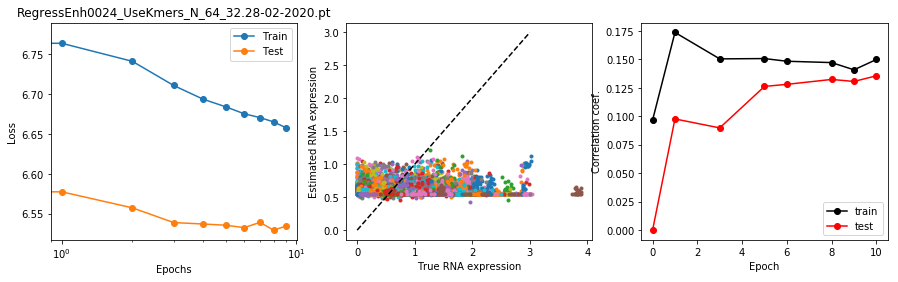

<Figure size 432x288 with 0 Axes>

In [ ]:
num_epochs1, num_epochs2 = 0, 200;

t0 = time.time()
batch_size = 2
train_hist = {'epoch': [], 'cc': []}
train_sample = random.sample(train.tolist(), 500)

for epoch in range(num_epochs1):  # loop over the dataset multiple times
    new_loss_train = train_epoch(epoch, phase=1);
    loss_train = np.append(loss_train, new_loss_train)
    
    new_loss_test = test_epoch(epoch, phase=1);
    loss_test = np.append(loss_test,new_loss_test)
    scheduler.step(new_loss_test)

    print('**** Phase1 epoch %d, LR=%3.5g, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (epoch, 
                    optimizer.param_groups[0]['lr'],
                    loss_train[-1], 
                    loss_test[-1], 
                    (time.time()-t0))
         )

    if (time.time()-t0)>20 or (epoch==num_epochs1-1):        
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_test': loss_test,
                }, fn_save)
        print('Saved data: %s' % fn_save)
        
        if (epoch>0):            
            cc = np.zeros((Nc,2))
            yyhat_train, cc[:,[0]] = test_net(train_sample)
            yyhat_test, cc[:,[1]] = test_net(test)
            display.clear_output(wait=True)
            make_plot1(save=True)
#             make_plot2(save=True)  
            display.display(plt.gcf())
        t0=time.time()
        
        train_hist['epoch'].append(epoch)
        train_hist['cc'].append(cc)


<Figure size 432x288 with 0 Axes>

Saved plot: Plots/RegressEnh0024_UseKmers_N_64_32.28-02-2020.pt_corrcoef.png


<Figure size 432x288 with 0 Axes>

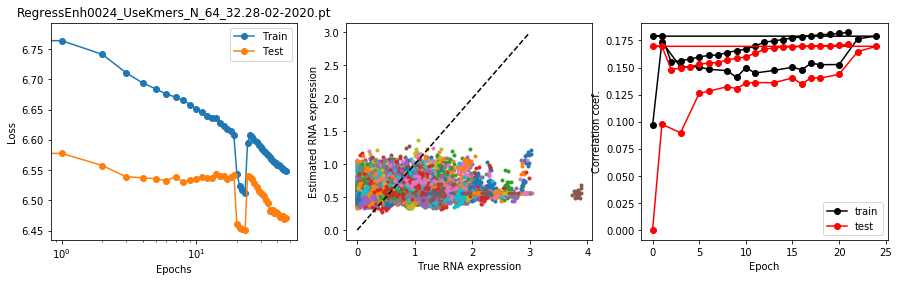

Saved data: RegressEnh0024_UseKmers_N_64_32.28-02-2020.pt
Epoch 23, i=1886/8661, LR=0.002, loss=6.89721047, t=5.001, 0.00265 s/sample


In [ ]:
batch_size = 2
t0 = time.time()

# Turn on the learning for kmers
net.fc1_kmers.requires_grad_(True)
# Reset the learning rate for the optimizer
optimizer = optim.Adam(net.parameters(), lr=lr) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.25)

for epoch in np.arange(num_epochs1, num_epochs2+num_epochs1):  # loop over the dataset multiple times
    new_loss_train = train_epoch(epoch);
    loss_train = np.append(loss_train,new_loss_train)
    
    new_loss_test = test_epoch(epoch);
    loss_test = np.append(loss_test,new_loss_test)
    scheduler.step(new_loss_test)


    print('**** Phase2 epoch %d, LR=%3.5g, loss_train=%3.8f, loss_test=%3.8f, time = %3.5f s/epoch' % (epoch, 
                    optimizer.param_groups[0]['lr'],
                    loss_train[-1], 
                    loss_test[-1], 
                    (time.time()-t0))
         )

    if (time.time()-t0)>20 or (epoch==num_epochs2-1):        
        if (epoch>1):            
            cc = np.zeros((Nc,2))
            yyhat_train, cc[:,[0]] = test_net(train_sample)
            yyhat_test, cc[:,[1]] = test_net(test)
            display.clear_output(wait=True)
            display.clear_output(wait=True)
            make_plot1(save=True)
#             make_plot2(save=True)  
            display.display(plt.gcf())
            t0=time.time()
        torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss_train': loss_train,
                'loss_test': loss_test,
                }, fn_save)
        print('Saved data: %s' % fn_save)  
        
        train_hist['epoch'].append(epoch)
        train_hist['cc'].append(cc)


In [ ]:
break

In [ ]:
batch_size = 2;
cc = np.zeros((Nc,2))
yyhat_train, cc[:,[0]] = test_net(random.sample(train.tolist(), 500))
yyhat_test, cc[:,[1]] = test_net(test)
make_plot1(save=True)
make_plot2(save=True)  

In [ ]:
break
# N = 64 x 32
# **** Epoch 39, LR=1e-05, loss_train=0.00182151, loss_test=0.00199540, time = 0.15510 s/epoch
# **** Epoch 0, LR=0.002, loss_train=6.51633886, loss_test=5.99391724, time = 19.92587 s/epoch

# N = 32 x 8
# **** Epoch 53, LR=1e-07, loss_train=0.00180459, loss_test=0.00203680, time = 0.12214 s/epoch
# **** Epoch 71, LR=0.00025, loss_train=0.00172845, loss_test=0.00188889, time = 0.09076 s/epoch


# N = 32 x 16
# **** Epoch 85, LR=0.000, loss_train=0.00167278, loss_test=0.00183274, time = 0.07683 s/epoch
# **** Epoch 65, LR=1e-06, loss_train=0.00168914, loss_test=0.00189639, time = 0.09208 s/epoch
# **** Epoch 53, LR=5e-07, loss_train=0.00172672, loss_test=0.00198197, time = 0.10991 s/epoch
# **** Epoch 58, LR=0.0005, loss_train=0.00167136, loss_test=0.00189098, time = 0.11401 s/epoch

# N = 16 x 8
# **** Epoch 53, LR=1e-05, loss_train=0.00177558, loss_test=0.00194236, time = 0.11628 s/epoch

# N = 4 x 4
# **** Epoch 66, LR=1.5625e-05, loss_train=0.00180230, loss_test=0.00197317, time = 0.09088 s/epoch


In [ ]:
optimizer.param_groups[0]['lr']

In [ ]:
2